# IE 48B Homework 02 - Dorukhan Kılınç 2017402093

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
import cvxpy as cp

## Task: Penalized Regression Approaches for Time Series Representation

In [53]:
data = []
for line in open("CBF_TRAIN.txt"):
    data.append(line.split())

data = np.array(data, dtype = "float")


### Subtask 1

For $k = 10$, we will have 10 validation splits in which the set for test data has the indices $i + 10n$, $i \in \{ 0,1,2,3,4,5,6,7,8,9\}$, $n \in \mathbb{N}$. 

In [4]:
#train-test split starting from start and lefting-out start+k*n th observations.
def k_train_test_split(k, start):
    array_train = np.ones(128)
    array_test = np.zeros(128)
    i = start
    while i < 128:
        array_train[i] = 0
        array_test[i] = 1
        i += k
    return array_train, array_test



For $\lambda$ validation, I used a set of $\lambda$'s from 0.1 to 5 with 0.1 increments. I used cvxpy package to write the minimization problem and solved it using these lambda sets for each instance using the training set, $t_{train}$. However, I still needed to tune the $\beta_{i}$'s where $i \notin t_{train}$ since they will be used in the model evaluation, so I constructed a vector $v$ whose i'th entry is 1 if $i \in t_{train}$ and 0 otherwise. Then instead of using the sum of squares function, I used the sum of squares function multiplied by $v$ elementwise to omit the usage of test set in the training of the model. 

Each $\lambda$ were used in construction of 10 models for each instance and then I evaluated the sum of squared errors of them to select the most resonable one. Originally, I wanted to select the $\lambda$ whose mean sse is the smallest sse which is also greater than the minimum of the mean sse's plus the corresponding deviation. However, deviations were so high such that such a $\lambda$ was not in the original set. Therefore, I used the $\lambda$ whose mean sse in the validation test sets were the smallest. 

All in all, 30 $\lambda$ values were selected such that each minimized the mean sse for the corresponding instance.

In [5]:
def lambda_validation(instance, lambdas):
    means = []
    stds = []
    for lmbda in lambdas:
        score = []
        for i in range(10):
            beta = cp.Variable(128)
            y = instance[1:]
            
            train, test = k_train_test_split(10, i)
            
            objective = cp.Minimize(cp.sum_squares(cp.multiply(y,train) - cp.multiply(beta, train))/2 + lmbda*(cp.tv(beta)))
            prob = cp.Problem(objective)
            prob.solve()
            
            sse = np.multiply(beta.value - y, test)
            sse = np.multiply(sse, sse)
            
            sse = np.sum(sse)
            
            score.append(sse)
            
        score = np.array(score)
        means.append(np.mean(score))
        stds.append(np.std(score))
        
        
    return np.array(means), np.array(stds)


In [6]:
lambdas = np.arange(0.1, 5.1, 0.1)

lambdas_selected = np.zeros(30)

for i in range(30):
    means, stds = lambda_validation(data[i,:], lambdas)
    lambdas_selected[i] = lambdas[np.argmin(means)]

print(lambdas_selected)

[0.7 2.2 0.7 1.2 1.  1.  1.5 1.  1.1 0.2 1.  1.1 0.8 1.3 1.4 1.2 0.5 1.2
 1.  0.4 0.8 1.2 1.2 1.3 1.1 0.8 1.2 1.2 0.6 0.6]


Here below are the visualization of fused lasso representations of each instance with their original time series. 

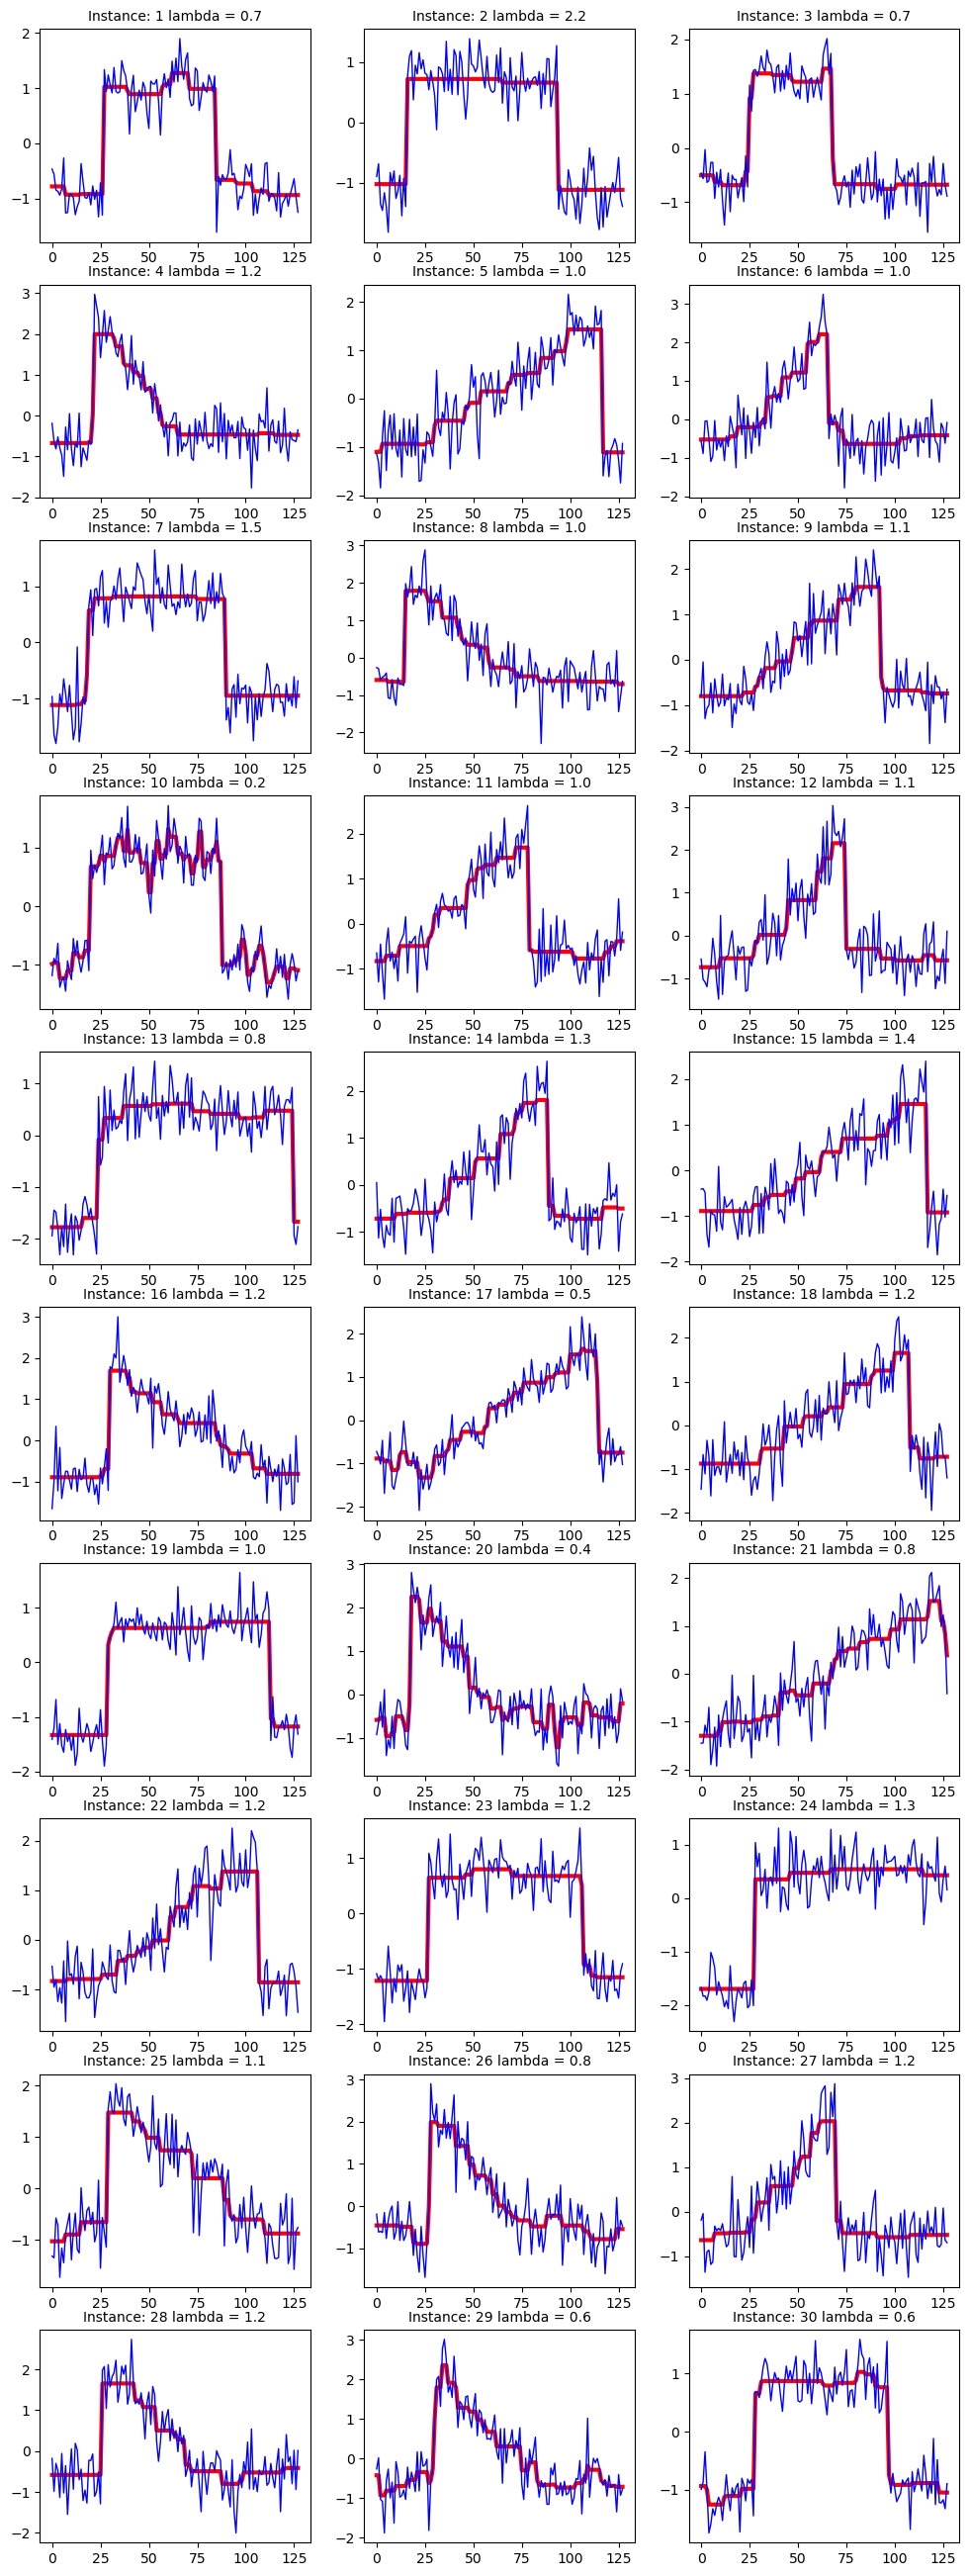

In [55]:
fig = plt.figure(figsize= (12,33))

for i in range(30):
    ax = fig.add_subplot(10, 3, i+1)
    beta = cp.Variable(128)
    lmbda = lambdas_selected[i]
    y = data[i,1:]
    objective = cp.Minimize(cp.sum_squares(y - beta)/2 + lmbda*(cp.tv(beta)))

    prob = cp.Problem(objective)
    prob.solve()
    
    ax.plot(beta.value, c = "r",linewidth=3.0)
    ax.plot(y, c = "b",linewidth=1.0)
    ax.set_title("Instance: " + str(i+1)+" lambda = " + str(round(lmbda,2)), size =10)

plt.show();

### Subtask 2

To do depth validation, I used the same validation technique I did in the first part and my candidates for depths were $\{1, 2, 3, 4, 5, 6, 7 \}$ since there are 128 observations and a max depth of 7 corresponds to 128 leaf nodes. I chose the depths minimizing the mean sse score in the validation sets.

In [8]:
def depth_validation(instance, depths):
    means = []
    stds = []
    for depth in depths:
        score = []
        for i in range(10):
            y = instance[1:]
            t = np.arange(128) 
            
            t_train = t[(t + i) % 10 != 0 ]
            t_test = t[(t + i) % 10 == 0 ]
            
            y_train = y[t_train]
            y_test = y[t_test]
            
            tree_regressor = DecisionTreeRegressor(random_state = 0, max_depth = depth,
                                              min_samples_split = 20, min_samples_leaf = 10)
            
            tree_regressor.fit(t_train.reshape(-1, 1), y_train)
            
            sse = np.mean((y_test - tree_regressor.predict(t_test.reshape(-1, 1)))**2)
            score.append(sse)
            
        score = np.array(score)
        means.append(np.mean(score))
        stds.append(np.std(score))
        
        
    return np.array(means), np.array(stds)

In [9]:
depths = np.arange(1,8)
depths_selected = np.zeros(30)

for i in range(30):
    means, stds = depth_validation(data[i,:], depths)
    depths_selected[i] = int(depths[np.argmin(means)])

print(depths_selected)

[5. 2. 2. 3. 5. 5. 2. 5. 5. 2. 4. 4. 4. 4. 4. 4. 5. 5. 2. 3. 3. 5. 2. 1.
 4. 4. 3. 4. 4. 2.]


Here below are the visualization of tree representations of each instance with their original time series. 

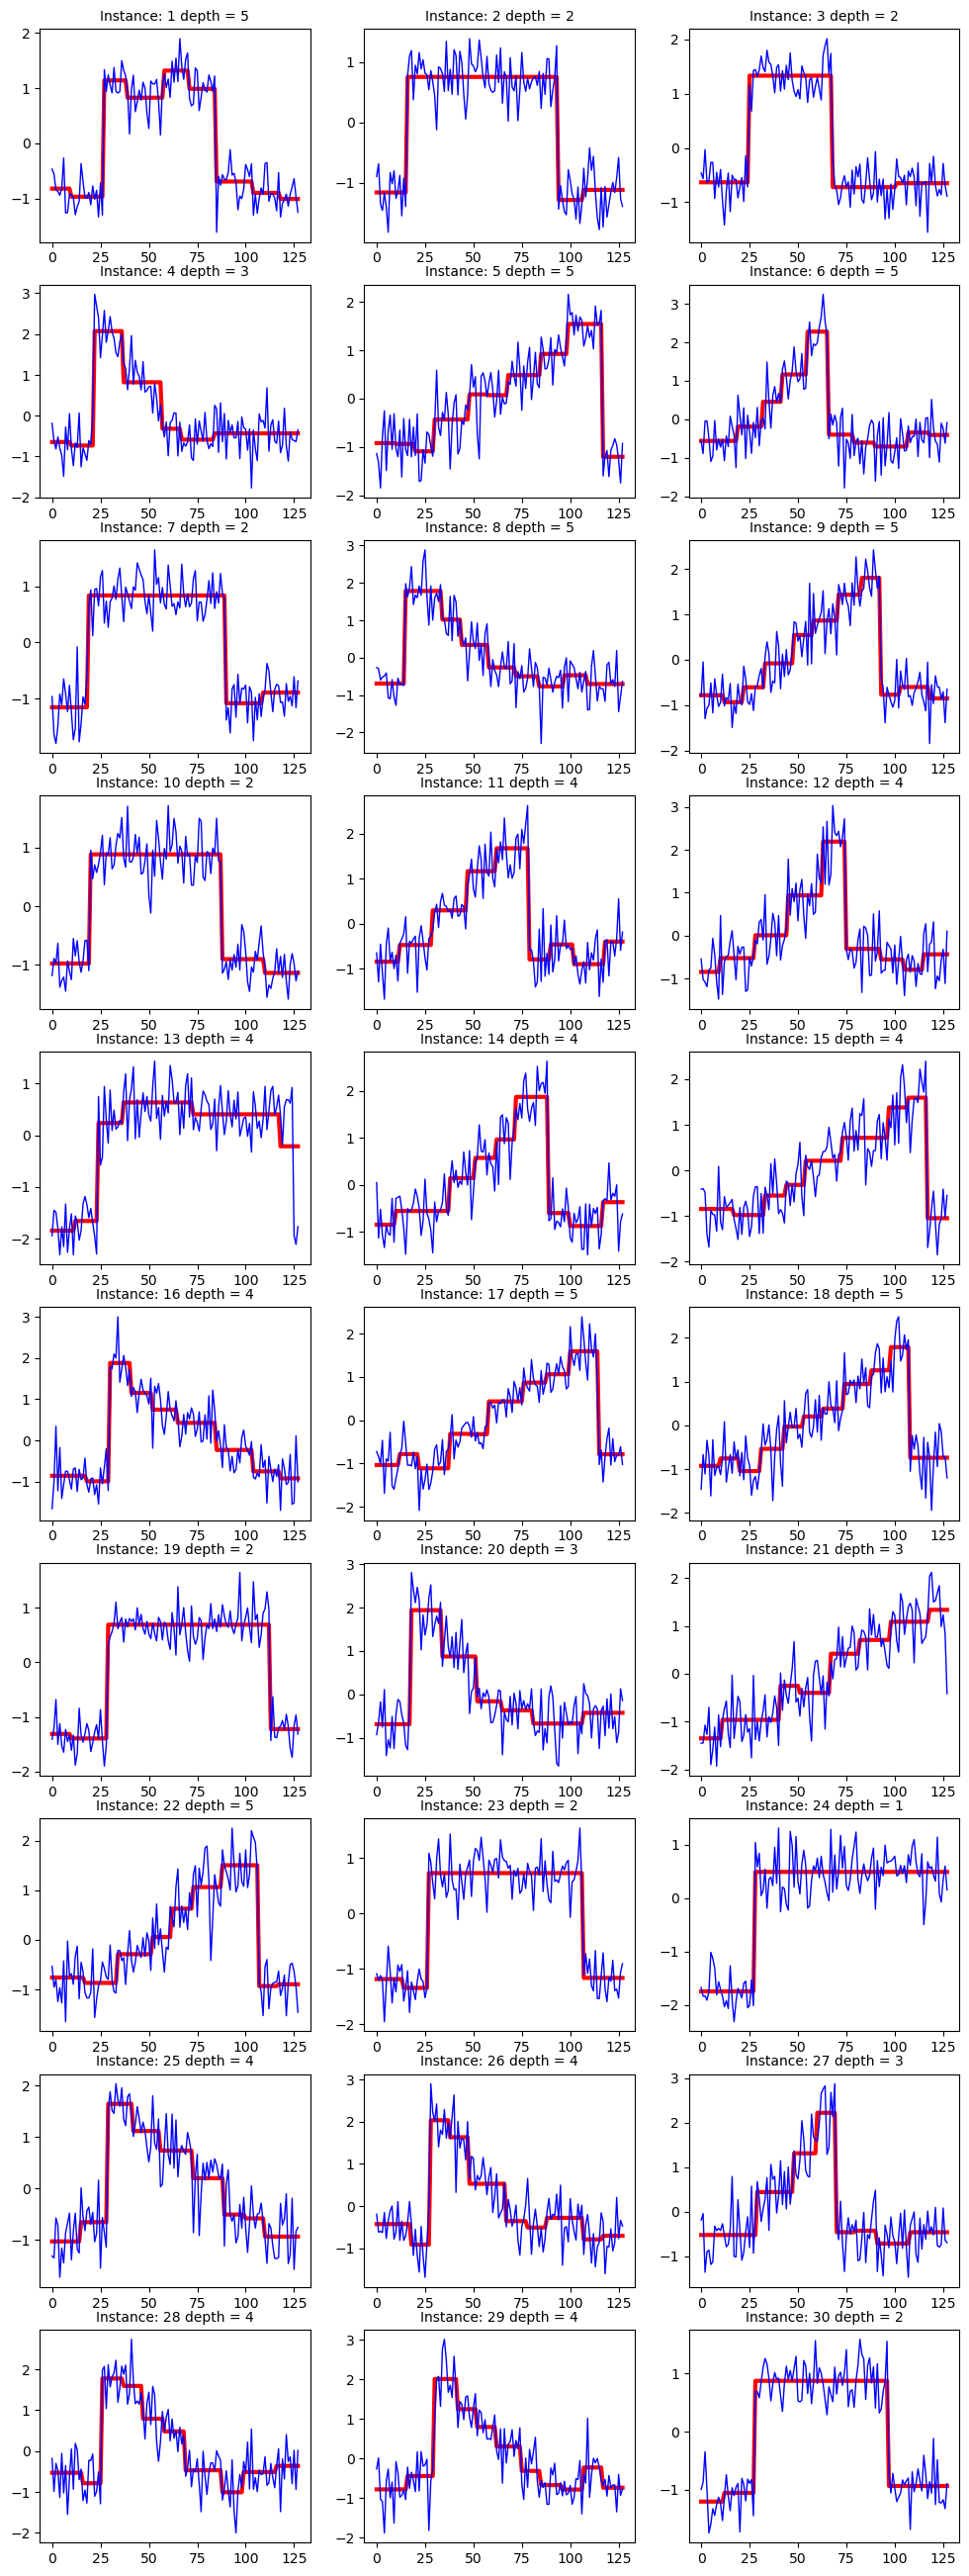

In [11]:
fig = plt.figure(figsize= (12,33))

for i in range(30):
    ax = fig.add_subplot(10, 3, i+1)
    depth = depths_selected[i]
    y = data[i,1:]
    t = np.arange(128)
    tree_regressor = DecisionTreeRegressor(random_state = 0, max_depth = depth,
                                              min_samples_split = 20, min_samples_leaf = 10)
            
    tree_regressor.fit(t.reshape(-1, 1), y)
    ax.plot(tree_regressor.predict(t.reshape(-1, 1)), c = "r",linewidth=3.0)
    ax.plot(y, c = "b",linewidth=1.0)
    ax.set_title("Instance: " + str(i+1)+" depth = " + str(int(depth)), size =10)


plt.show();

### Subtask 3

In [62]:
errors_lasso = []
errors_tree = []

for i in range(30):
    beta = cp.Variable(128)
    lmbda = lambdas_selected[i]
    y = data[i,1:]
    objective = cp.Minimize(cp.sum_squares(y - beta)/2 + lmbda*(cp.tv(beta)))

    prob = cp.Problem(objective)
    prob.solve()
    
    errors_lasso.append(np.mean((beta.value - y)**2))
    
    depth = depths_selected[i]
    t = np.arange(128)
    tree_regressor = DecisionTreeRegressor(random_state = 0, max_depth = depth,
                                              min_samples_split = 20, min_samples_leaf = 10)
            
    tree_regressor.fit(t.reshape(-1, 1), y)
    errors_tree.append(np.mean((tree_regressor.predict(t.reshape(-1, 1)) - y)**2))
    

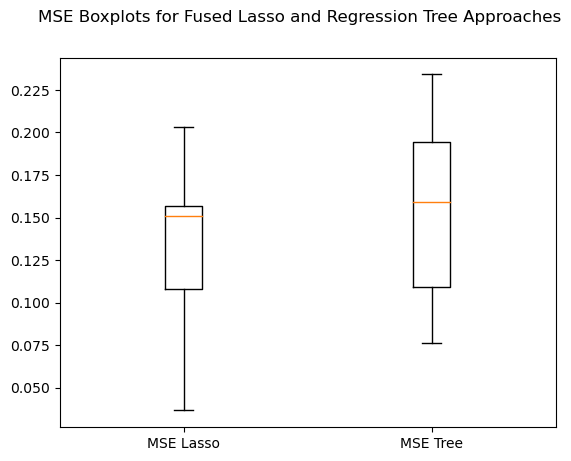

In [63]:
my_dict = {'MSE Lasso': errors_lasso, 'MSE Tree': errors_tree}

fig, ax = plt.subplots()
fig.suptitle("MSE Boxplots for Fused Lasso and Regression Tree Approaches")
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
plt.show();

As we can see from the plots above, lasso representation is a better representation in the sense that it has less MSE values in general. This may be because fused lasso predicts 128 parameters but the regression tree constructs splits in which the predicted value for each leaf node is the mean of the observations falling in it.

### Subtask 4

In [46]:
dist_matrix = np.eye(30) * 10000
dist_matrix_lasso = np.eye(30) *100000
dist_matrix_tree = np.eye(30) * 10000

for i in range(30):
    for j in range(i+1, 30):
        
        dist_matrix[i,j] = sum((data[i,1:] - data[j,1:])**2)
        dist_matrix[j,i] = dist_matrix[i,j]
        
        beta1 = cp.Variable(128)
        lmbda1 = lambdas_selected[i]
        y1 = data[i,1:]
        objective1 = cp.Minimize(cp.sum_squares(y1 - beta1)/2 + lmbda1*(cp.tv(beta1)))
        prob1 = cp.Problem(objective1)
        prob1.solve()
        
        beta2 = cp.Variable(128)
        lmbda2 = lambdas_selected[j]
        y2 = data[j,1:]
        objective2 = cp.Minimize(cp.sum_squares(y2 - beta2)/2 + lmbda2*(cp.tv(beta2)))
        prob2 = cp.Problem(objective2)
        prob2.solve()
        
        dist_matrix_lasso[i,j] = sum((beta1.value - beta2.value)**2)
        dist_matrix_lasso[j,i] = dist_matrix_lasso[i,j]
        
        
        depth1 = depths_selected[i]
        t = np.arange(128)
        tree_regressor1 = DecisionTreeRegressor(random_state = 0, max_depth = depth1,
                                              min_samples_split = 20, min_samples_leaf = 10)
            
        tree_regressor1.fit(t.reshape(-1, 1), y1)
        
        depth2 = depths_selected[i]
        t = np.arange(128)
        tree_regressor2 = DecisionTreeRegressor(random_state = 0, max_depth = depth2,
                                              min_samples_split = 20, min_samples_leaf = 10)
            
        tree_regressor2.fit(t.reshape(-1, 1), y2)
        
        dist_matrix_tree[i,j] = sum((tree_regressor1.predict(t.reshape(-1, 1)) - tree_regressor2.predict(t.reshape(-1, 1)))**2)
        dist_matrix_tree[j,i] = dist_matrix_tree[i,j]


To construct the 1-NN classifier for the raw time series and the representations, I constructed a distance matrix using euclidian metric for them. I assigned a very large value for the diagonals so that the argmin function I applied to each row to find the closest neighbor wouldn't return the instance itself. Then, I assigned the class of the nearest neighbor to each instance.

In [47]:
raw_classifications = []
lasso_representation_classifications = []
tree_representation_classifications = []

for i in range(30):    
    raw_classifications.append(data[np.argmin(dist_matrix[i,:]), 0])
    lasso_representation_classifications.append(data[np.argmin(dist_matrix_lasso[i,:]), 0])
    tree_representation_classifications.append(data[np.argmin(dist_matrix_tree[i,:]), 0])
    

In [48]:
d = {'Class': data[:,0], 'Raw NN': raw_classifications,
    "Lasso NN": lasso_representation_classifications, 
     "Tree NN":tree_representation_classifications}
df = pd.DataFrame(data = d)
df

,Class,Raw NN,Lasso NN,Tree NN
0,1.0,3.0,3.0,3.0
1,1.0,1.0,1.0,1.0
2,1.0,3.0,3.0,3.0
3,3.0,3.0,3.0,3.0
4,2.0,2.0,2.0,2.0
5,2.0,2.0,2.0,2.0
6,1.0,1.0,1.0,1.0
7,3.0,3.0,3.0,3.0
8,2.0,2.0,2.0,2.0
9,1.0,1.0,1.0,1.0


In [65]:
print("Acccuracy in raw time series 1-NN: " +str(len(df[df["Class"] == df["Raw NN"]])/30))
print("Accuracy in lasso representation 1-NN: " +str(len(df[df["Class"] == df["Lasso NN"]])/30))
print("Accuracy in tree representation 1-NN: " +str(len(df[df["Class"] == df["Tree NN"]])/30))

Acccuracy in raw time series 1-NN: 0.8333333333333334
Accuracy in lasso representation 1-NN: 0.9333333333333333
Accuracy in tree representation 1-NN: 0.8666666666666667
